Transformer(2017)는 인코더 (입력) & 디코더(출력) 인 반면에 GPT1은 디코더만 남기고 언어모델에 최적화를 하려고 했음
GPT-1은 Transformer 디코더 구조를 기반으로 한 언어 모델로, 사전 학습과 전이 학습의 개념을 도입함

### 1. GPT1에서 바뀐 주요 부분
1) 학습 가능한 포지셔널 인코딩 (Learned Positional Encodings)
   - 기존의 사인(sinusoidal) 방식 대신 학습 가능한 임베딩을 사용하도록 변경
2) 인코터 부분 삭제
3) 디코더 전용 아키텍처 (Decoder-Only Architecture)
   - GPT-1 스타일의 마스크드 셀프 어텐션(Masked Self-Attention)을 적용
4) 패드 마스킹은 삭제하고 Look-ahead Masking만 사용

### 2. 모델의 입력 형태에 맞게 전처리 수행
GPT-1은 디코더 기반의 생성 모델로, 학습 시 이전 토큰들을 기반으로 다음 토큰을 예측할수 있도록, 데이터를 디코더 블록에 맞춰 변형함
질문 및 답변 데이터를 토큰화한 후, 길이를 맞추기 위해 패딩화하여, GPT-1 모델에 맞는 형태로 변형하였음

### 3. GPT 논문 기반 수정 사항
입력 블록 수정: GPT-1 논문을 참고하여 positional encoding을 적용하고, 임베딩된 단어 벡터를 GPT-1에 맞게 구성함
모델 구조 변경: Multi-Head Attention 블록과 Feed Forward Network를 통해 문장을 처리하고, 각 레이어 뒤에 Layer Normalization을 적용함
Positional Encoding 적용: 각 문장에 위치 정보를 추가함
Layer Normalization과 Dropout 적용: 안정적인 학습을 위해 각 레이어 뒤에 Normalization과 Dropout을 추가함

### 4. Model.summary()
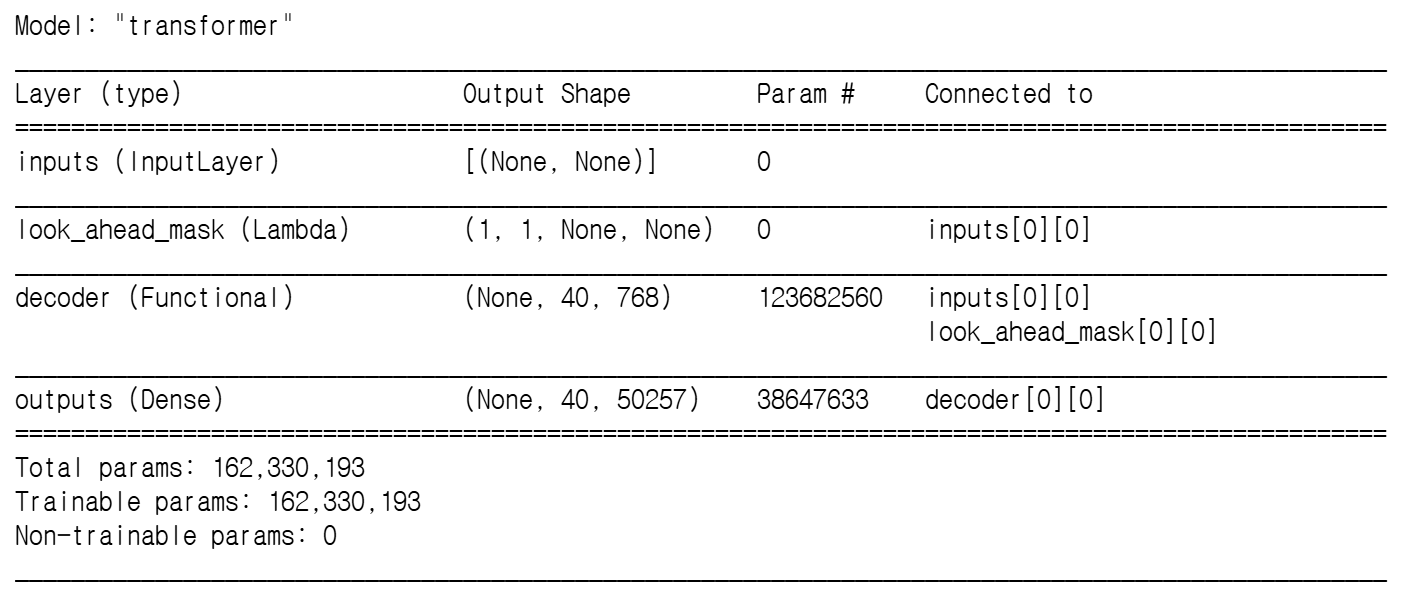

### 5. Model.fit()
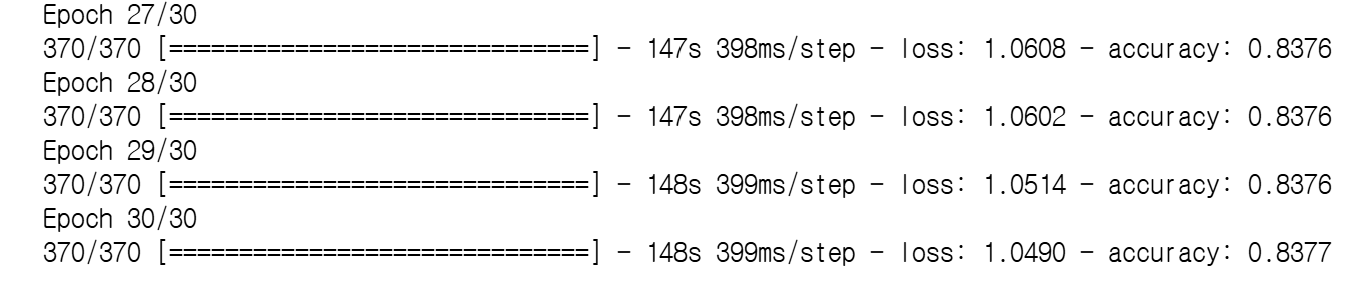

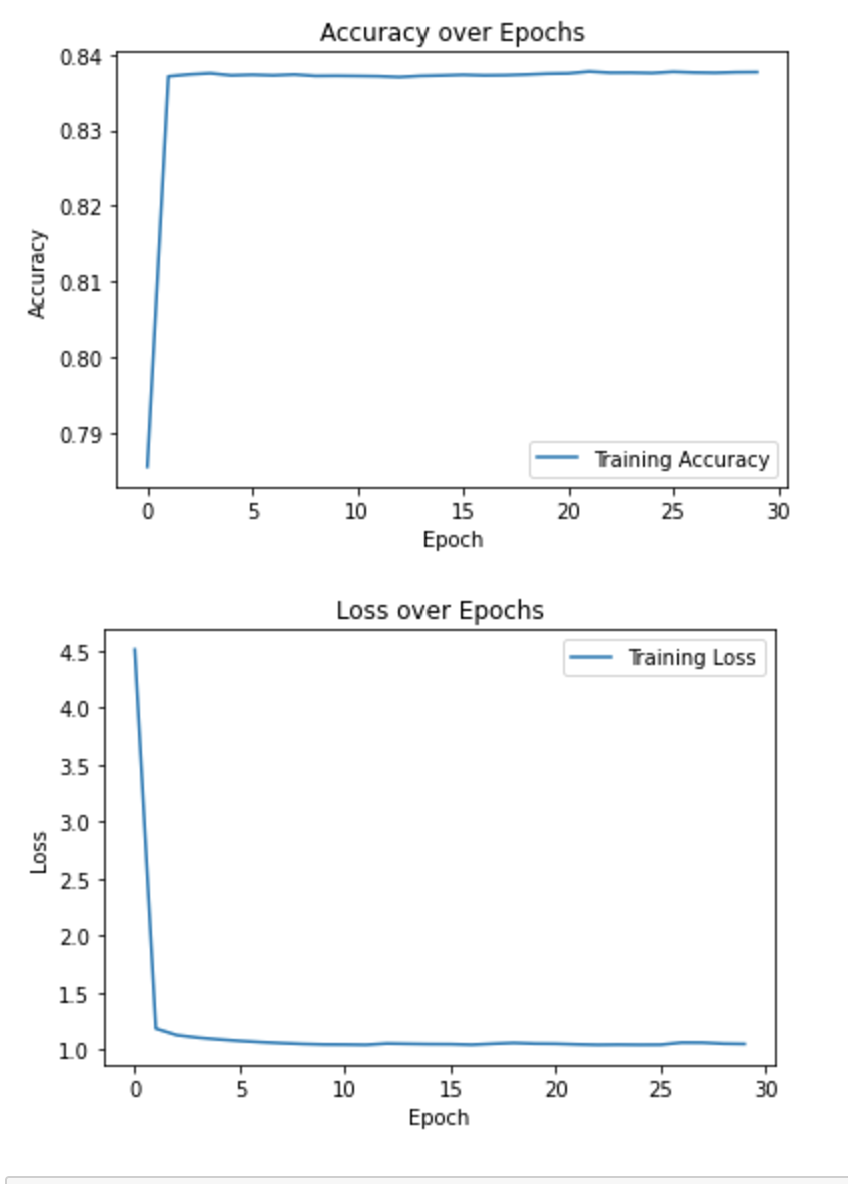

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print("슝=3")

슝=3


In [2]:
# 1. 학습 가능한 포지셔널 인코딩 레이어
# 바뀐 부분: 기존의 사인(sinusoidal) 포지셔널 인코딩을 학습 가능한 포지셔널 임베딩으로 교체
#            이전 코드에서 사용되던 tf.math.sin 및 tf.math.cos는 학습 가능한 가중치(self.pos_embedding)로 대체
# 삭제된 부분: get_angles와 같은 사인/코사인 값을 계산하는 함수, 고정된 방식으로 포지셔널 정보를 생성하던 방법

class PositionalEncoding(tf.keras.layers.Layer): 
    def __init__(self, max_position, d_model):
        """
        학습 가능한 포지셔널 인코딩 레이어 초기화
        Args:
            max_position: 최대 시퀀스 길이 (포지셔널 인코딩의 크기 설정)
            d_model: 임베딩 차원 (모델의 숨겨진 상태 크기)
        """
        super(PositionalEncoding, self).__init__()
        
        # 학습 가능한 포지셔널 임베딩 정의
        self.pos_embedding = self.add_weight(
            "pos_embedding",  # 가중치 이름
            shape=[max_position, d_model],  # (최대 시퀀스 길이, 임베딩 차원)
            initializer=tf.keras.initializers.RandomNormal(mean=0., stddev=1.),  # 초기화: 평균 0, 표준편차 1
            trainable=True,  # 학습 가능하도록 설정
        )

    def call(self, inputs):
        """
        입력에 포지셔널 임베딩을 더함
        Args:
            inputs: 입력 텐서 (shape: [batch_size, seq_length, d_model])
        Returns:
            입력 + 포지셔널 임베딩이 더해진 텐서
        """
        # 입력 시퀀스 길이를 추출 (동적 크기 처리)
        seq_length = tf.shape(inputs)[1]
        
        # 입력 텐서에 포지셔널 임베딩 추가
        # pos_embedding은 [max_position, d_model] 크기에서 필요한 부분만 사용
        return inputs + self.pos_embedding[:seq_length, :]   


In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)
    
    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(depth)
    
    # 패딩에 마스크 추가
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)
        
    # softmax적용
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)
    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

In [4]:
# scaled_dot_product_attention 함수 호출 시 mask가 사용되는 부분이 GPT-1의 "Masked Self-Attention"을 반영

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0

        self.depth = d_model // num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, query, key, value, mask):
        batch_size = tf.shape(query)[0]

        # Linear layers for Q, K, V
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # Split heads for multi-head attention
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # Scaled dot-product attention
        # 추가된 부분: 마스크(mask)를 적용하여 미래 정보(미래 토큰)를 참조하지 않도록 설정
        attention, _ = scaled_dot_product_attention(query, key, value, mask) 
        # `mask`는 미래 토큰을 차단하기 위해 look-ahead mask가 전달됨.
        # 마스크가 적용된 경우, 해당 위치의 attention weight는 무시됨.
        
        # Concatenate heads
        concat_attention = tf.reshape(attention, (batch_size, -1, self.d_model))

        # Final dense layer
        output = self.dense(concat_attention)

        return output


패드 마스킹은 삭제하고 Look-ahead Masking만 사용

In [6]:
def create_look_ahead_mask(x):
    """
    Generate a look-ahead mask for the input sequence.
    """
    seq_len = tf.shape(x)[1]  # Sequence length
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    look_ahead_mask = tf.reshape(look_ahead_mask, (1, 1, seq_len, seq_len))  # Reshape for batch compatibility
    return look_ahead_mask

삭제 : 인코더 층, 인코더

디코더 하나의 레이어를 함수로 만들기

In [7]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name="decoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")  # Input shape
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name="look_ahead_mask")

    # Embedding and positional encoding
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
    embeddings = PositionalEncoding(MAX_LENGTH, d_model)(embeddings)
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # Decoder layers
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name=f"decoder_layer_{i}"
        )(inputs=[outputs, look_ahead_mask])

    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=outputs, name=name)


디코더 층을 쌓아 디코더 만들기

In [8]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    """
    Define a single decoder layer with consistent input shapes.
    """
    inputs = tf.keras.Input(shape=(MAX_LENGTH, d_model), name="inputs")  # Updated shape
    look_ahead_mask = tf.keras.Input(shape=(1, MAX_LENGTH, MAX_LENGTH), name="look_ahead_mask")

    # Masked Multi-Head Attention
    attention = MultiHeadAttention(d_model, num_heads, name="masked_self_attention")(
        query=inputs, key=inputs, value=inputs, mask=look_ahead_mask
    )
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs + attention)

    # Feed-forward network
    outputs = tf.keras.layers.Dense(units=units, activation="relu")(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(inputs=[inputs, look_ahead_mask], outputs=outputs, name=name)


데이터 가져오기

In [9]:
# CSV 파일 
data = pd.read_csv('~/aiffel/transformer_chatbot/data/ChatbotData .csv')
print(data.head()) # 데이터 확인print("데이터 샘플:")
print("총 데이터 수 :", len(data))

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0
총 데이터 수 : 11823


데이터 전처리

In [10]:
# 전처리
def preprocess_sentence(sentence):
    # 입력받은 sentence를 양쪽 공백을 제거
    sentence = sentence.strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'["]+', " ", sentence)

    # (ㄱ-ㅎ, 가-힣, a-z, A-Z, 0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백으로 대체합니다. (숫자+한글+영어+문장부호)
    sentence = re.sub(r"[^ㄱ-ㅎ가-힣a-zA-Z0-9?.!,]+", " ", sentence) #정규표현식
    sentence = sentence.strip()
    return sentence



In [11]:
# data['Q']와 data['A']에 대해 질문과 답변 쌍 생성 함수
def load_conversations(data):
    inputs, outputs = [], []
    for q, a in zip(data['Q'], data['A']):
        # 전처리 함수를 질문에만 적용 (답변에는 적용하지 않음)
        inputs.append(preprocess_sentence(q))
        outputs.append(a)
    return inputs, outputs

# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.
questions, answers = load_conversations(data)

print('전체 샘플 수 :', len(questions))
print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [12]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)
print("슝=3 ")

슝=3 


In [13]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8171]
END_TOKEN의 번호 : [8172]


In [14]:
# 단어장의 크기 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8173


In [15]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5762, 611, 2492, 4162]
정수 인코딩 후의 21번째 답변 샘플: [2357, 7509, 7, 6274, 97, 7961]


In [16]:
# 데이터프레임 열에 대해 최대 길이를 추출하는 함수
def get_max_length_for_column(dataframe, column_name):
    return max(len(sentence.split()) for sentence in dataframe[column_name])

# data 데이터프레임의 'Q' 열에 대해 최대 길이 추출
max_len_questions = get_max_length_for_column(pd.DataFrame(data), 'Q')
print('질문 최대 길이:', max_len_questions)

# data 데이터프레임의 'A' 열에 대해 최대 길이 추출
max_len_questions = get_max_length_for_column(pd.DataFrame(data), 'A')
print('대답 최대 길이:', max_len_questions)

질문 최대 길이: 15
대답 최대 길이: 21


In [17]:

MAX_LENGTH = 32


In [18]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []

  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 40 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)

  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')

  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [19]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8173
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


In [20]:
# BATCH_SIZE = 64
# BUFFER_SIZE = 12000

# # 디코더는 이전의 target을 다음의 input으로 사용합니다.
# # 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
# # dataset = tf.data.Dataset.from_tensor_slices((
# #     {
# #         'inputs': questions,
# #         'dec_inputs': answers[:, :-1]
# #     },
# #     {
# #         'outputs': answers[:, 1:]
# #     },
# # ))

# dataset = tf.data.Dataset.from_tensor_slices((
#     {
#         'inputs': questions
#     },
#     {
#         'outputs': answers[:, 1:]
#     },
# ))


# dataset = dataset.cache()
# dataset = dataset.shuffle(BUFFER_SIZE)
# dataset = dataset.batch(BATCH_SIZE)
# dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
# print("슝=3")
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# MAX_LENGTH 설정 (모델과 동일하게)
MAX_LENGTH = 40

# 데이터 전처리: 입력 데이터와 출력 데이터 모두 패딩 처리
def preprocess_dataset(inputs, outputs):
    inputs = pad_sequences(inputs, maxlen=MAX_LENGTH, padding='post', truncating='post')
    outputs = pad_sequences(outputs, maxlen=MAX_LENGTH, padding='post', truncating='post')
    return inputs, outputs

# 데이터가 이미 정의되어 있다고 가정 (questions, answers)
# questions와 answers가 적절히 준비되었다고 가정
inputs = questions
outputs = answers

# 전처리 수행
inputs, outputs = preprocess_dataset(inputs, outputs)



# TensorFlow Dataset 생성
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': inputs[:, :-1],
        'dec_inputs': outputs[:, :-1]  # Decoder 입력 (마지막 토큰 제외)
    },
    {
        'outputs': outputs[:, 1:]  # Decoder 출력 (첫 번째 토큰 제외)
    },
))
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 데이터셋 확인
for batch in dataset.take(1):
    print("Input shape:", batch[0]['inputs'].shape)  # 질문 데이터
    print("Decoder Input shape:", batch[0]['dec_inputs'].shape)  # 디코더 입력
    print("Output shape:", batch[1]['outputs'].shape)  # 디코더 출력

Input shape: (32, 39)
Decoder Input shape: (32, 39)
Output shape: (32, 39)


In [21]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

# MAX_LENGTH 설정 (모델과 동일하게)
MAX_LENGTH = 40

# 데이터 전처리: 입력 데이터와 출력 데이터 모두 패딩 처리
def preprocess_dataset(inputs, outputs):
    # 입력 데이터와 출력 데이터 모두 동일한 MAX_LENGTH로 패딩
    inputs = pad_sequences(inputs, maxlen=MAX_LENGTH, padding='post', truncating='post')
    outputs = pad_sequences(outputs, maxlen=MAX_LENGTH, padding='post', truncating='post')
    return inputs, outputs

# 데이터셋에 적용
try:
    inputs, outputs = preprocess_dataset(inputs, outputs)
except NameError:
    print("Error: `raw_questions`와 `raw_answers`가 정의되지 않았습니다.")
    # 데이터가 정의되지 않았다면 예외 처리 후 종료
    raise

# TensorFlow Dataset 생성
batch_size = 32  # 배치 크기 설정
dataset = tf.data.Dataset.from_tensor_slices((inputs, outputs))
dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# 데이터셋 구조 확인
for batch in dataset.take(1):
    print("Input shape:", batch[0].shape)  # 질문 데이터
    print("Output shape:", batch[1].shape)  # 정답 데이터




Input shape: (32, 40)
Output shape: (32, 40)


Transformer 중 인코더 부분을 제외하고 수정함

In [22]:
def transformer(vocab_size, num_layers, units, d_model, num_heads, dropout, name="transformer"):
    """
    GPT-1 style Transformer with decoder-only architecture.
    """
    # Input for the decoder
    inputs = tf.keras.Input(shape=(None,), name="inputs")  # Tokenized input sequence
    
    # Look-Ahead Mask
    look_ahead_mask = tf.keras.layers.Lambda(
        lambda x: create_look_ahead_mask(x),
        name="look_ahead_mask"
    )(inputs)
    
    # Decoder Layers
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, look_ahead_mask])  # No encoder outputs
    
    # Final Output Dense Layer
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)


모델 생성하기

In [23]:
tf.keras.backend.clear_session()

# Hyperparameters
NUM_LAYERS = 12  # Number of decoder layers (typical for GPT-1)
D_MODEL = 768    # Hidden size
NUM_HEADS = 12   # Number of attention heads
UNITS = 3072     # Feedforward network hidden size
DROPOUT = 0.1    # Dropout rate

# Vocabulary size should match your tokenizer
VOCAB_SIZE = 50257  # Example size for OpenAI GPT tokenizer

# Build the GPT-like model
model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
)

model.summary()


Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (1, 1, None, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Functional)            (None, 40, 768)      123682560   inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, 40, 50257)    38647633    decoder[0][0]          

손실함수

In [25]:
def loss_function(y_true, y_pred):
    # y_pred의 길이에 맞춰 y_true를 reshape
    y_true = tf.reshape(y_true, shape=(-1, tf.shape(y_pred)[1]))

    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    return tf.reduce_mean(loss)

학습률

In [26]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        # step을 float32로 변환
        step = tf.cast(step, tf.float32) # 타입 맞춰주기
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

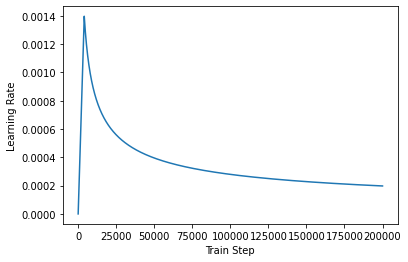

In [27]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [28]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    # 여기도 y_pred의 길이에 맞춰 y_true를 reshape
    y_true = tf.reshape(y_true, shape=(-1, tf.shape(y_pred)[1]))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [29]:
# Train the model
EPOCHS = 30
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/30
370/370 [==============================] - 158s 388ms/step - loss: 4.5122 - accuracy: 0.7855
Epoch 2/30
370/370 [==============================] - 147s 398ms/step - loss: 1.1841 - accuracy: 0.8371
Epoch 3/30
370/370 [==============================] - 148s 399ms/step - loss: 1.1263 - accuracy: 0.8374
Epoch 4/30
370/370 [==============================] - 148s 399ms/step - loss: 1.1042 - accuracy: 0.8375
Epoch 5/30
370/370 [==============================] - 148s 399ms/step - loss: 1.0884 - accuracy: 0.8372
Epoch 6/30
370/370 [==============================] - 148s 399ms/step - loss: 1.0755 - accuracy: 0.8373
Epoch 7/30
370/370 [==============================] - 147s 399ms/step - loss: 1.0647 - accuracy: 0.8372
Epoch 8/30
370/370 [==============================] - 148s 399ms/step - loss: 1.0560 - accuracy: 0.8373
Epoch 9/30
370/370 [==============================] - 148s 399ms/step - loss: 1.0491 - accuracy: 0.8372
Epoch 10/30
370/370 [==============================] - 148s 399m

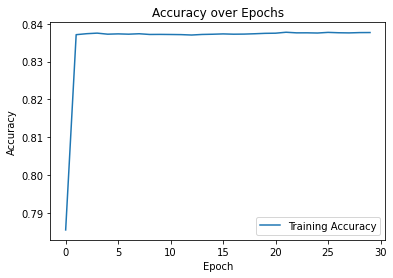

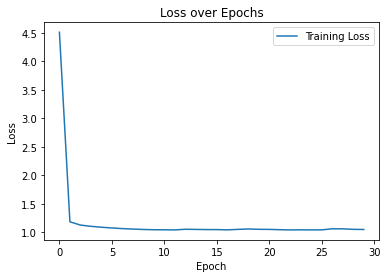

In [31]:
# Plot Training History
plt.plot(history.history['accuracy'], label='Training Accuracy')
#plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [288]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [289]:
def sentence_generation(sentence):
    # 입력 문장을 정수 시퀀스로 변환
    sentence = tokenizer.encode(sentence)
    sentence = pad_sequences([sentence], maxlen=MAX_LENGTH, padding='post')

    # 디코더 입력 초기화 (시작 토큰 추가)
    output_sequence = tf.constant([[START_TOKEN]], dtype=tf.int32)  # 2D로 초기화

    # output_sequence를 항상 3D로 유지
    output_sequence = tf.expand_dims(output_sequence, axis=-1)  # (1, 1, 1)

    for i in range(MAX_LENGTH):
        # 모델을 통해 다음 토큰 예측
        predictions = model(inputs=sentence, training=False)
        predictions = predictions[:, -1:, :]  # 마지막 토큰 예측 결과만 가져옴
        predicted_id = tf.argmax(predictions, axis=-1, output_type=tf.int32)  # tf.int32로 변환

        # predicted_id를 3D로 변환
        predicted_id = tf.reshape(predicted_id, [1, 1, 1])  # 3D로 확장

        # 출력 시퀀스에 추가
        output_sequence = tf.concat([output_sequence, predicted_id], axis=1)  # 3D 연결

    # 최종 시퀀스를 1D로 변환
    output_sequence = tf.squeeze(output_sequence, axis=-1)  # (1, seq_len)
    return tokenizer.decode(output_sequence.numpy().flatten())

In [291]:
#sentence_generation("안녕하세요")

In [53]:
def preprocess_input(sentence, tokenizer, max_length):
    # 문장을 정수 시퀀스로 변환
    sentence = tokenizer.encode(sentence)
    # MAX_LENGTH로 패딩
    sentence = tf.keras.preprocessing.sequence.pad_sequences(
        [sentence], maxlen=max_length, padding='post', truncating='post'
    )
    return sentence

In [54]:
def evaluate(sentence, temperature=1.0):
    # 입력 데이터 전처리
    sentence = preprocess_input(sentence, tokenizer, MAX_LENGTH)  # MAX_LENGTH에 맞게 패딩
    sentence = tf.constant(sentence, dtype=tf.int32)  # 텐서로 변환

    # 디코더 입력 초기화 (시작 토큰 추가)
    output_sequence = tf.constant([[START_TOKEN]], dtype=tf.int32)  # 2D 초기화

    for i in range(MAX_LENGTH):
        # 모델을 통해 다음 토큰 예측
        predictions = model(inputs=sentence, training=False)  # (1, MAX_LENGTH, vocab_size)
        predictions = predictions[:, -1:, :]  # 마지막 토큰의 예측 결과만 가져옴 (1, 1, vocab_size)
        predictions = predictions / temperature

        # argmax로 다음 토큰 선택
        predicted_id = tf.argmax(predictions, axis=-1, output_type=tf.int32)  # (1, 1)
        predicted_id = tf.expand_dims(predicted_id, axis=-1)  # (1, 1, 1)

        print(f"Step {i}: predicted_id = {predicted_id.numpy().flatten()}")

        # 종료 토큰이면 중단
        if tf.equal(predicted_id[0, 0, 0], END_TOKEN):
            break

        # 출력 시퀀스에 추가
        output_sequence = tf.concat([output_sequence, predicted_id], axis=1)  # 3D 연결

    # 최종 출력 시퀀스를 텍스트로 변환
    print(f"Final output_sequence: {output_sequence.numpy()}")
    output_sequence = tf.squeeze(output_sequence, axis=-1)  # (1, seq_len)
    return output_sequence


In [55]:
def predict(sentence, temperature=1.0):
    prediction = evaluate(sentence, temperature)
    print(f"Decoded prediction before decode: {prediction.numpy().flatten()}")

    # 올바른 디코딩 수행
    predicted_sentence = tokenizer.decode(
        [i for i in prediction.numpy().flatten() if i < tokenizer.vocab_size]
    )

    print('Input:', sentence)
    print('Predicted:', predicted_sentence)
    return predicted_sentence


In [59]:
# output = predict('배고프다', temperature=1.5)